# Data generation for HEP.TrkX discrete extrapolators

For development and testing of the data generation and manipulation for discrete detector track finding methods.

In [1]:
# Externals
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from data import (draw_event, calc_mask_ranges, construct_mask,
                  apply_det_mask, expand_masked_data,
                  generate_straight_track, generate_straight_tracks,
                  generate_track_bkg, generate_uniform_noise)

# Magics
%matplotlib notebook

## 1D fixed width straight tracks

<IPython.core.display.Javascript object>


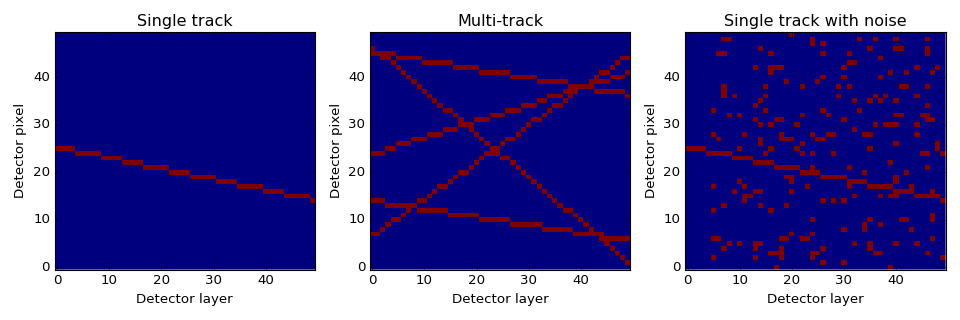

In [2]:
# First, generate a single-track event for a fixed width 1D detector
det_shape = det_depth, det_width = 50, 50
track = generate_straight_track(det_shape)

# A multi-track event
multi_track = sum(generate_straight_tracks(5, det_shape))
multi_track[multi_track > 1] = 1

# Single track with uniform noise
noise = generate_uniform_noise(1, det_shape, prob=0.1)[0]
noise_track = track + noise
noise_track[noise_track > 1] = 1

# Draw the events
plt.figure(figsize=(12,4))
plt.subplot(131)
draw_event(track, title='Single track')
plt.subplot(132)
draw_event(multi_track, title='Multi-track')
plt.subplot(133)
draw_event(noise_track, title='Single track with noise')

## Masking a rectangular detector to a variable-width detector
This is how I want to generate variable-width layer detector data: start with a rectangular layout, and then select the desired range of pixels in each layer.

<IPython.core.display.Javascript object>


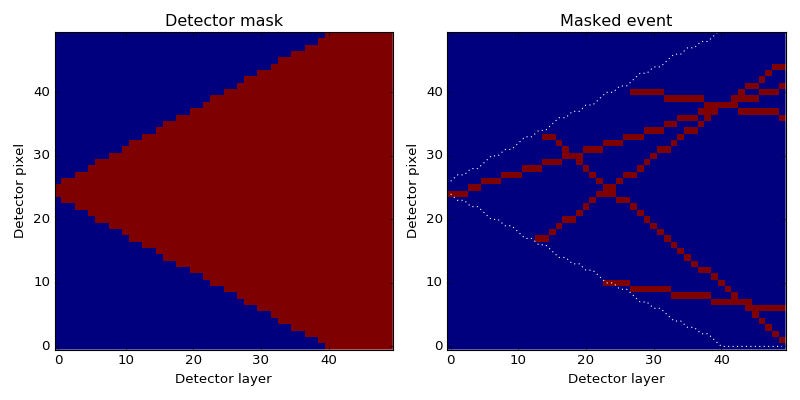

In [3]:
# Test detector mask
mask_shapes = (np.arange(1, det_depth+1)/1.7 + 1).astype(int)*2
# Clip mask at detector size
mask_shapes[mask_shapes > det_width] = det_width
det_mask = construct_mask(det_shape, mask_shapes)
mask_ranges = calc_mask_ranges(det_width, mask_shapes)

# Mask the multi-track event
masked_multi_track = apply_det_mask(np.array([multi_track]), det_mask)
# Convert back to rectangular for display
rect_multi_track = expand_masked_data(masked_multi_track, det_mask)[0]

# Draw the mask and the masked event
plt.figure(figsize=(10,5))
plt.subplot(121)
draw_event(det_mask, title='Detector mask')
plt.subplot(122)
draw_event(rect_multi_track, mask_ranges=mask_ranges, title='Masked event')

## Data generation for masked detector
Now we need to be able to generate signal tracks constrained to the detector mask region, and generate background tracks in the entire detector volume. I've generalized the data-generation code to meet these requirements.

In [6]:
# Demonstrate generation of full events
num_event = 10

# Generate signal tracks in the masked region
entry_range = (mask_ranges[0][0], mask_ranges[1][0])
exit_range = (mask_ranges[0][-1], mask_ranges[1][-1])
sig_tracks = generate_straight_tracks(num_event, det_shape, entry_range, exit_range)

# Generate backgrounds
bkg_tracks = generate_track_bkg(num_event, det_shape, tracks_per_event=4, skip_layers=5)
noise = generate_uniform_noise(num_event, det_shape, prob=0.01)

# Combine into full events
events = sig_tracks + bkg_tracks + noise
events[events > 1] = 1

# Mask the events
masked_events = apply_det_mask(events, det_mask)
# Unmask for drawing
unmasked_events = expand_masked_data(masked_events, det_mask)

<IPython.core.display.Javascript object>


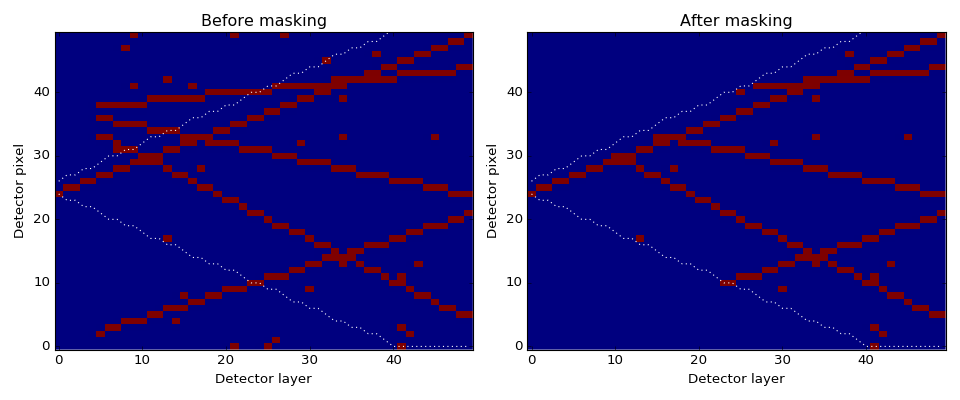

In [7]:
# Draw the event before/after masking
plt.figure(figsize=(12, 5))
plt.subplot(121)
draw_event(events[0], mask_ranges=mask_ranges, title='Before masking')
plt.subplot(122)
draw_event(unmasked_events[0], mask_ranges=mask_ranges, title='After masking')

## Discussion

Awesome, I can now generate data with variable width detector layers including track backgrounds as well as uniform random noise!

Still missing from here:
* Ability to unmask prediction sample which is missing the first layer

Things to do next:
* Train on this data and see how well it does
* Compare the masked-data with advanced LSTM architecture to the simpler rectangular data with simple LSTM architecture. It's still not clear that there's an advantage in the complicated approach.